# How to add multi-turn conversation in a multi-agent application
- https://langchain-ai.github.io/langgraph/how-tos/multi-agent-multi-turn-convo/

In [1]:
import random
from typing import Annotated, Literal
from langchain_core.tools import tool
from langchain_core.tools.base import InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.types import Command


@tool
def get_travel_recommendations():
    """Get recommendation for travel destinations"""
    return random.choice(["aruba", "turks and caicos"])


@tool
def get_hotel_recommendations(location: Literal["aruba", "turks and caicos"]):
    """Get hotel recommendations for a given destination."""
    return {
        "aruba": [
            "The Ritz-Carlton, Aruba (Palm Beach)"
            "Bucuti & Tara Beach Resort (Eagle Beach)"
        ],
        "turks and caicos": ["Grace Bay Club", "COMO Parrot Cay"],
    }[location]


def make_handoff_tool(*, agent_name: str):
    """Create a tool that can return handoff via a Command"""
    tool_name = f"transfer_to_{agent_name}"

    @tool(tool_name)
    def handoff_to_agent(
        state: Annotated[dict, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Ask another agent for help."""
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": tool_name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            # navigate to another agent node in the PARENT graph
            goto=agent_name,
            graph=Command.PARENT,
            # This is the state update that the agent `agent_name` will see when it is invoked.
            # We're passing agent's FULL internal message history AND adding a tool message to make sure
            # the resulting chat history is valid.
            update={"messages": state["messages"] + [tool_message]},
        )

    return handoff_to_agent

In [2]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt import create_react_agent, InjectedState
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver


model = ChatOpenAI(model="gpt-4o-mini")

# Define travel advisor tools and ReAct agent
travel_advisor_tools = [
    get_travel_recommendations,
    make_handoff_tool(agent_name="hotel_advisor"),
]
travel_advisor = create_react_agent(
    model,
    travel_advisor_tools,
    prompt=(
        "You are a general travel expert that can recommend travel destinations (e.g. countries, cities, etc). "
        "If you need hotel recommendations, ask 'hotel_advisor' for help. "
        "You MUST include human-readable response before transferring to another agent."
    ),
)


def call_travel_advisor(
    state: MessagesState,
) -> Command[Literal["hotel_advisor", "human"]]:
    # You can also add additional logic like changing the input to the agent / output from the agent, etc.
    # NOTE: we're invoking the ReAct agent with the full history of messages in the state
    response = travel_advisor.invoke(state)
    return Command(update=response, goto="human")


# Define hotel advisor tools and ReAct agent
hotel_advisor_tools = [
    get_hotel_recommendations,
    make_handoff_tool(agent_name="travel_advisor"),
]
hotel_advisor = create_react_agent(
    model,
    hotel_advisor_tools,
    prompt=(
        "You are a hotel expert that can provide hotel recommendations for a given destination. "
        "If you need help picking travel destinations, ask 'travel_advisor' for help."
        "You MUST include human-readable response before transferring to another agent."
    ),
)


def call_hotel_advisor(
    state: MessagesState,
) -> Command[Literal["travel_advisor", "human"]]:
    response = hotel_advisor.invoke(state)
    return Command(update=response, goto="human")


def human_node(
    state: MessagesState, config
) -> Command[Literal["hotel_advisor", "travel_advisor", "human"]]:
    """A node for collecting user input."""

    user_input = interrupt(value="Ready for user input.")

    # identify the last active agent
    # (the last active node before returning to human)
    langgraph_triggers = config["metadata"]["langgraph_triggers"]
    if len(langgraph_triggers) != 1:
        raise AssertionError("Expected exactly 1 trigger in human node")

    active_agent = langgraph_triggers[0].split(":")[1]

    return Command(
        update={
            "messages": [
                {
                    "role": "human",
                    "content": user_input,
                }
            ]
        },
        goto=active_agent,
    )


builder = StateGraph(MessagesState)
builder.add_node("travel_advisor", call_travel_advisor)
builder.add_node("hotel_advisor", call_hotel_advisor)

# This adds a node to collect human input, which will route
# back to the active agent.
builder.add_node("human", human_node)

# We'll always start with a general travel advisor.
builder.add_edge(START, "travel_advisor")


checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

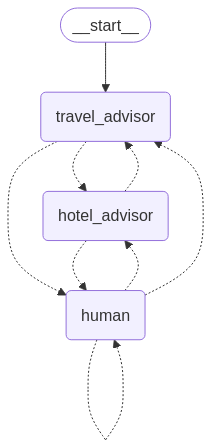

In [3]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

### Test multi-turn conversation

In [4]:
import uuid

thread_config = {"configurable": {"thread_id": uuid.uuid4()}}

inputs = [
    # 1st round of conversation,
    {
        "messages": [
            {"role": "user", "content": "i wanna go somewhere warm in the caribbean"}
        ]
    },
    # Since we're using `interrupt`, we'll need to resume using the Command primitive.
    # 2nd round of conversation,
    Command(
        resume="could you recommend a nice hotel in one of the areas and tell me which area it is."
    ),
    # 3rd round of conversation,
    Command(
        resume="i like the first one. could you recommend something to do near the hotel?"
    ),
]

for idx, user_input in enumerate(inputs):
    print()
    print(f"--- Conversation Turn {idx + 1} ---")
    print()
    print(f"User: {user_input}")
    print()
    for update in graph.stream(
        user_input,
        config=thread_config,
        stream_mode="updates",
    ):
        for node_id, value in update.items():
            if isinstance(value, dict) and value.get("messages", []):
                last_message = value["messages"][-1]
                if isinstance(last_message, dict) or last_message.type != "ai":
                    continue
                print(f"{node_id}: {last_message.content}")


--- Conversation Turn 1 ---

User: {'messages': [{'role': 'user', 'content': 'i wanna go somewhere warm in the caribbean'}]}

travel_advisor: I recommend Aruba as a warm destination in the Caribbean. It's known for its stunning beaches, crystal-clear waters, and delightful weather year-round. You can enjoy a variety of activities such as snorkeling, windsurfing, or simply relaxing on the beautiful sandy shores. Let me know if you need hotel recommendations for your stay!

--- Conversation Turn 2 ---

User: Command(resume='could you recommend a nice hotel in one of the areas and tell me which area it is.')

hotel_advisor: In Aruba, I recommend the following hotels:

1. **The Ritz-Carlton, Aruba** (Location: Palm Beach) - This luxurious resort features stunning ocean views, a variety of dining options, and a beautiful beachfront.

2. **Bucuti & Tara Beach Resort** (Location: Eagle Beach) - An adult-only resort known for its romantic atmosphere, it offers a serene environment and excelle